In [1]:
!python --version

Python 3.9.0


# Developing a Handwritten Digits Classifier with PyTorch

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST can be found on [**Yann LeCun's page**](http://yann.lecun.com/exdb/mnist/) and include:

- 88% [**Lecun et al., 1998**](https://hal.science/hal-03926082/document)
- 95.3% [**Lecun et al., 1998**](https://hal.science/hal-03926082v1/document)
- 99.65% [**Ciresan et al., 2011**](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Load the Dataset

MNIST is fortunately included in the torchvision module. Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` (the documentation is available [**here**](https://pytorch.org/vision/stable/datasets.html)). Make sure to specify `download=True`.

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load dataset with training-validation split
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

train_size, val_size = 50000, 10000
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [5]:
# Create training and validation set and define dataloader
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

In [6]:
# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

<font color="red"> 

I chose the `ToTensor()` transform because PyTorch models require tensor inputs. The `Normalize((0.5,), (0.5,))` transform was applied to scale the pixel values from [0,1] to [-1,1], which helps stabilize training and improves convergence. Normalization ensures that the input distribution remains centered, making gradient updates more effective. No additional preprocessing was needed since MNIST images are already grayscale and well-structured.

</font>

## Explore the Dataset

Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument. Remember that normalized images will look really weird to you. You may want to try changing your transforms to view images. Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network. If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
# The shape of the train and test data
print(trainset.data.shape, testset.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [8]:
print(f"Train set size: {len(trainloader.dataset)}\nValidation set size: {len(valloader.dataset)}")

Train set size: 50000
Validation set size: 10000


In [9]:
# The 10 classes in the dataset
classes = trainset.classes

def show5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        image = images[i].numpy()
        image = image * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(np.transpose(image, (1, 2, 0)))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    
    plt.show()

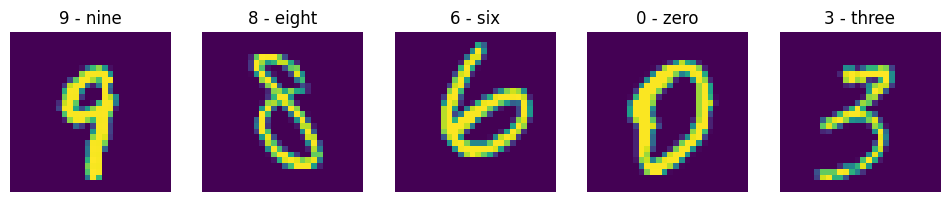

In [10]:
# Explore train data
show5(trainloader)

## Build your Neural Network

Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. Use any architecture you like. 

**Note**: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network.

In [11]:
# Define the CNN model
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
    
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Instantiate model
model = CNN()

Specify a loss function and an optimizer, and instantiate the model. If you use a less common loss function, please note why you chose that loss function in a comment.

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3
)

## Running your Neural Network

Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU.

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracy = 100 * (train_correct / train_total)
    train_accuracies.append(train_accuracy)
    

    # Validation phase
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(valloader))
    val_accuracy = 100 * (val_correct / val_total)
    val_accuracies.append(val_accuracy)

    print(
        "Epoch [{:02d}/{}] loss: {:.4f} - acc: {:.2f}% - val_loss {:.4f} - val_acc: {:.2f}%".format(
        epoch+1, epochs, train_losses[-1], train_accuracy, val_losses[-1], val_accuracy)
    )

Epoch [01/10] loss: 0.2237 - acc: 93.04% - val_loss 0.0794 - val_acc: 97.58%
Epoch [02/10] loss: 0.0555 - acc: 98.29% - val_loss 0.0587 - val_acc: 98.22%
Epoch [03/10] loss: 0.0370 - acc: 98.81% - val_loss 0.0627 - val_acc: 98.21%
Epoch [04/10] loss: 0.0287 - acc: 99.09% - val_loss 0.0490 - val_acc: 98.54%
Epoch [05/10] loss: 0.0224 - acc: 99.26% - val_loss 0.0514 - val_acc: 98.59%
Epoch [06/10] loss: 0.0162 - acc: 99.43% - val_loss 0.0525 - val_acc: 98.58%
Epoch [07/10] loss: 0.0148 - acc: 99.52% - val_loss 0.0531 - val_acc: 98.57%
Epoch [08/10] loss: 0.0121 - acc: 99.59% - val_loss 0.0520 - val_acc: 98.83%
Epoch [09/10] loss: 0.0103 - acc: 99.63% - val_loss 0.0551 - val_acc: 98.73%
Epoch [10/10] loss: 0.0102 - acc: 99.69% - val_loss 0.0515 - val_acc: 98.81%


Plot the training loss/accuracy and validation loss/accuracy.

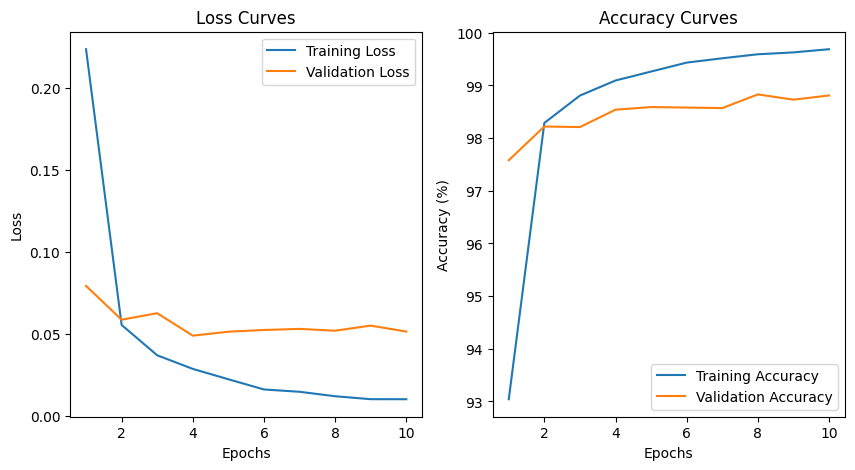

In [15]:
# Plot loss and accuracy curves for training and validation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

## Testing your model

Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further. If your accuracy is under 90%, you'll need to make improvements. Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
# Evaluate on test set
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

accuracy = 100 * (test_correct / test_total)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.94%


## Saving your model

Using `torch.save`, save your model for future loading.

In [17]:
# Save model
torch.save(model.state_dict(), "mnist_cnn.pth")